In [1]:
# Import the FEMSystem Class from directory above
import sys
sys.path.append('..')
from FEMSystem import FEMSystem

import jax.numpy as jnp
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
pickled_obj = {}

with open('./newplots/results.pkl', 'rb') as f:
    pickled_obj= pickle.load(f)

femsystem:FEMSystem = pickled_obj["femsystem"]
femsystem.saveFigsDir = None # Turn OFF saving plots
u_even,u_odd = pickled_obj["u_even"],pickled_obj["u_odd"]
u_even_interior,u_odd_interior = u_even[femsystem.interior_dofs],u_odd[femsystem.interior_dofs]
theta_at_dofs = pickled_obj["theta_at_dofs"]
n,N,coeffs = pickled_obj["n"],pickled_obj["N"],pickled_obj["coeffs"]

: 

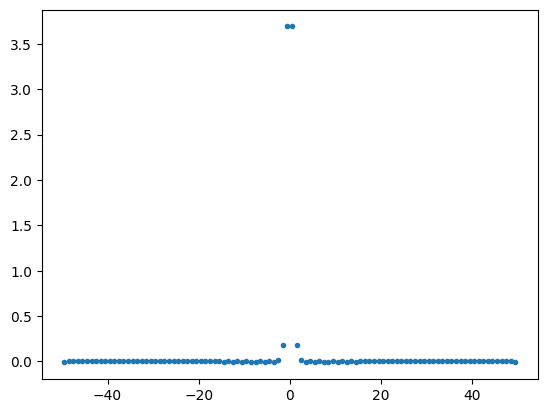

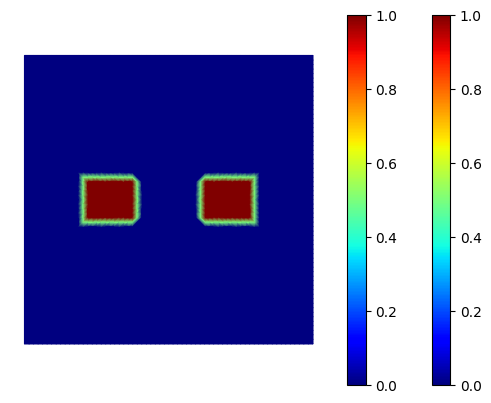

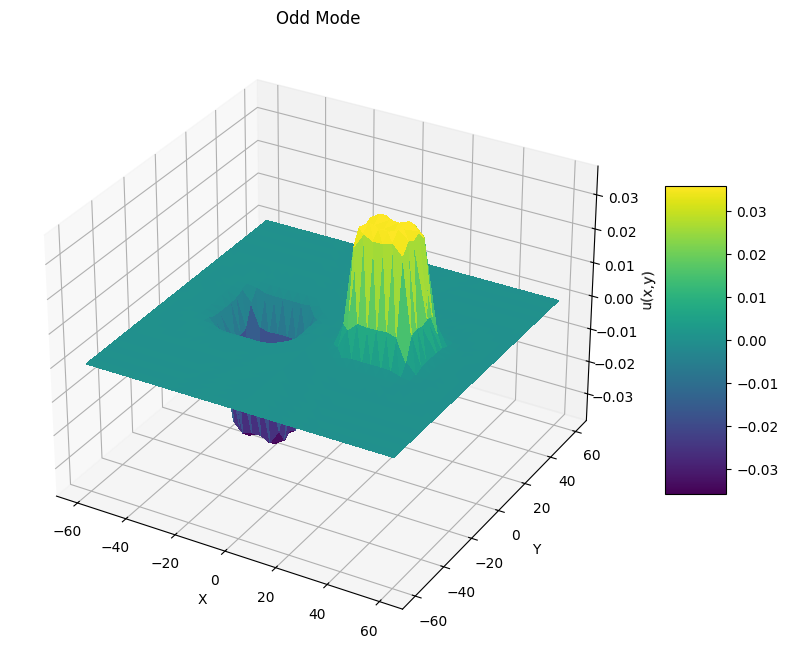

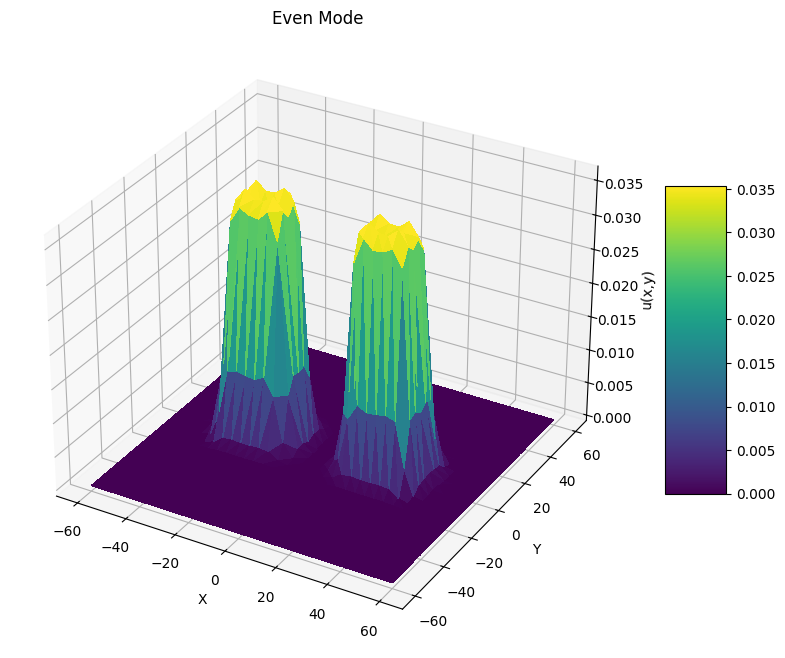

In [3]:
x = (n-1)/2 - jnp.arange(n)
plt.plot(x,coeffs,".")
femsystem.plot_at_interior_2d(theta_at_dofs[femsystem.interior_dofs])
femsystem.plot_at_interior_2d_in3d(u_odd_interior,plot_title="Odd Mode")
femsystem.plot_at_interior_2d_in3d(u_even_interior,plot_title="Even Mode")

In [ ]:
integrated_area = femsystem.integrate(lambda u,grad_u,x: u,theta_at_dofs)
G_mat = femsystem.get_greens_kernel()

# U_{++++} or U_{----}, Really N * \alpha
def alpha(u,G_mat):
    return integrated_area  * femsystem.double_integral(lambda u1,a,b,c,d: u1**2,lambda u1,a,b,c,d: u1**2,G_mat,u,u)

# U_{+--+} = U{-++-} - Remember middle two are wrt to y, Outer two wrt to x, from notation used in doc
def beta(u1_arg,u2_arg,G_mat):
    return integrated_area * femsystem.double_integral(lambda u1,a,b,c,d: u1**2, lambda a,b,u2,c,d: u2**2, G_mat, u1_arg,u2_arg)

# U_{++--} = U{+-+-}
def gamma(u1_arg,u2_arg,G_mat):
    return integrated_area * femsystem.double_integral(lambda u1,a,u2,c,d: u1*u2, lambda u1,b,u2,c,d: u1*u2, G_mat, u1_arg,u2_arg)

lambda_y = 2*beta(u_even,u_odd,G_mat) - alpha(u_even,G_mat)- alpha(u_odd,G_mat)
lambda_x = lambda_y + 4*gamma(u_even,u_odd,G_mat)
print(lambda_y,lambda_x)

/scratch/gpfs/AROD/vc9839/finite-island-cqed/jax-gpu/lib64/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/scratch/gpfs/AROD/vc9839/finite-island-cqed/jax-gpu/lib64/python3.9/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


-0.027877808 198.76384


: 

# Visualize Sweep

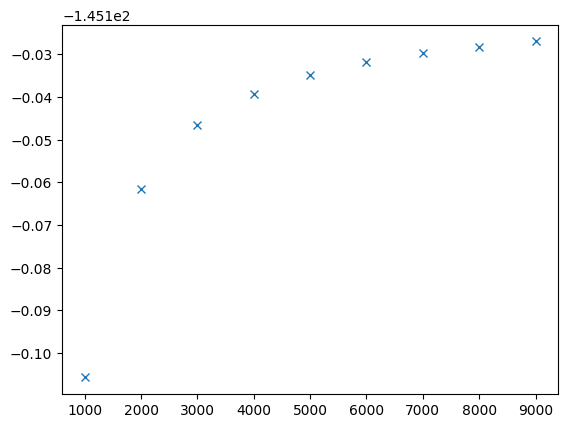

In [7]:
pickled_objs = []
separations = np.arange(1,29,3)
Ns = np.arange(1000,10000,1000)

# Get all pickled objects
for N in Ns:
    pickled_obj = {}

    with open(f'./phasetransitiontry4/{N}/results.pkl', 'rb') as f:
        pickled_obj= pickle.load(f)

    pickled_objs.append(pickled_obj)

energies = [p["objective"] for p in pickled_objs]
coeffs_per_sep = np.array([p["coeffs"] for p in pickled_objs])
n = pickled_objs[0]['n']
x = (n-1)/2 - jnp.arange(n)
plt.plot(Ns,energies,"x")

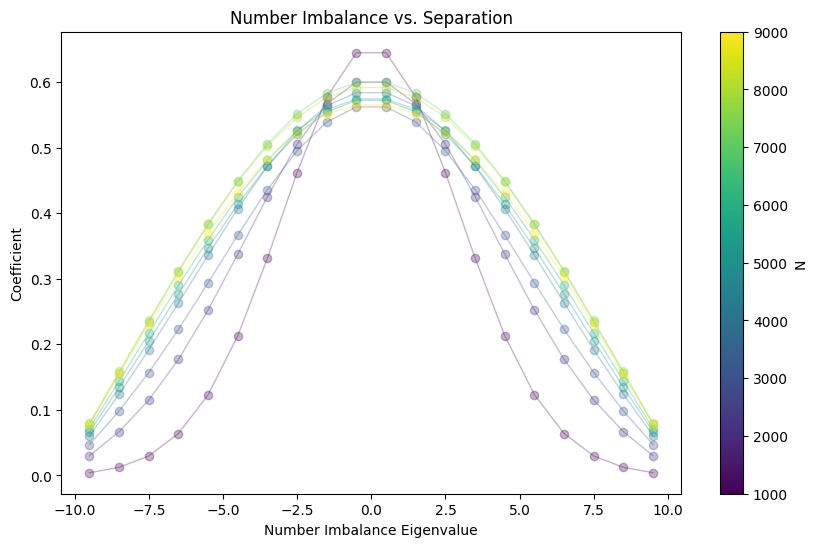

In [ ]:
# 3. Choose Colormap and Normalize Color Values
# Select a colormap (e.g., 'viridis')
cmap = plt.get_cmap('viridis')

color_values = Ns 
num_plots = len(color_values)

# Normalize the color values to range [0, 1] for the colormap
norm = plt.Normalize(vmin=np.min(color_values), vmax=np.max(color_values))

# 4. Create the Plot
fig, ax = plt.subplots(figsize=(10, 6))

middle = 10

# Iterate and Plot each line
for i in range(num_plots):
    # Get the color for the i-th plot from the colormap
    line_color = cmap(norm(color_values[i]))

    # Plot the line with:
    # - `color`: Based on the auxiliary array
    # - `alpha`: Transparency (e.g., 0.1 to 0.5) to reveal overlap/density

    s,e = len(x) // 2 - middle, len(x) //2 + middle

    ax.plot(x[s:e], coeffs_per_sep[i, s:e],color=line_color, marker="o", linestyle="-",alpha=0.3, linewidth=1)

# 5. Add a Colorbar for Reference
# The 'heatmap' effect is due to density, but a colorbar is needed
# to explain what the color of the individual lines represents.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # Needs to be set to an empty array for Matplotlib < 3.1
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('N')

# 6. Final Touches
ax.set_title(f'Number Imbalance vs. N')
ax.set_ylabel('Coefficient')
ax.set_xlabel('Number Imbalance Eigenvalue')
# ax.set_yscale('log')
plt.show()

In [ ]:
# Plot Energy
